In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):

        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [4]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size, padding=0):
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(padding, int):
            padding = (padding, padding)
        h_out = shape[0] - kernel_size[0] + 2 * padding[0] + 1
        w_out = shape[1] - kernel_size[1] + 2 * padding[1] + 1
        return (h_out, w_out)


    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [5]:
class LinearStackedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, abs_bnorm=False,
                 bias=True, stack_chan=None, stack_ksize=3, drop_p=0, padding=0):
        super().__init__()
        # Just a stack of small conv layers
        self.conv1 = nn.Conv2d(in_channels, stack_chan or in_channels, kernel_size=stack_ksize, padding=padding, bias=bias)
        self.conv2 = nn.Conv2d(stack_chan or in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)
        self.dropout = nn.Dropout2d(drop_p) if drop_p > 0 else nn.Identity()

    def forward(self, x):
        x = self.dropout(self.conv1(x))
        return self.conv2(x)

class AbsBatchNorm1d(nn.BatchNorm1d):
    def forward(self, input):
        self.weight.data = self.weight.abs()
        return super().forward(input)

class AbsBatchNorm2d(nn.BatchNorm2d):
    def forward(self, input):
        self.weight.data = self.weight.abs()
        return super().forward(input)

class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class OneToOneLinearStackedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, bias=True):
        super().__init__()
        assert in_channels == out_channels, "in_channels must equal out_channels for one-to-one"
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 1, kernel_size=kernel_size, padding=padding, bias=bias)
            for _ in range(in_channels)
        ])

    def forward(self, x):
        splits = torch.split(x, 1, dim=1)
        return torch.cat([conv(s) for conv, s in zip(self.convs, splits)], dim=1)


In [6]:
class LinearStackedBNCNN(TDRModel):
    def __init__(self, drop_p=0, one2one=False, stack_ksizes=3,
                 stack_chans=None, paddings=None, **kwargs):
        super().__init__(**kwargs)
        self.name = 'StackedNet'
        self.drop_p = drop_p
        self.one2one = one2one

        if isinstance(stack_ksizes, int):
            stack_ksizes = [stack_ksizes for _ in range(len(self.ksizes))]
        self.stack_ksizes = stack_ksizes

        if stack_chans is None or isinstance(stack_chans, int):
            stack_chans = [stack_chans for _ in range(len(self.ksizes))]
        self.stack_chans = stack_chans

        self.paddings = [0 for _ in self.stack_ksizes] if paddings is None else paddings

        shape = self.img_shape[1:]
        self.shapes = []
        modules = []

        ##### First Layer
        if one2one:
            conv = OneToOneLinearStackedConv2d(
                self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0],
                padding=self.paddings[0], bias=self.bias
            )
        else:
            conv = LinearStackedConv2d(
                self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0],
                abs_bnorm=False, bias=self.bias,
                stack_chan=self.stack_chans[0], stack_ksize=self.stack_ksizes[0],
                drop_p=self.drop_p, padding=self.paddings[0]
            )
        modules.append(conv)
        shape = self.update_shape(shape, self.ksizes[0], self.paddings[0])

        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            print("Flattened size before Linear:", size)
            modules.append(AbsBatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(AbsBatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        ##### Second Layer
        if one2one:
            conv = OneToOneLinearStackedConv2d(
                self.chans[0], self.chans[1], kernel_size=self.ksizes[1],
                padding=self.paddings[1], bias=self.bias
            )
        else:
            conv = LinearStackedConv2d(
                self.chans[0], self.chans[1], kernel_size=self.ksizes[1],
                abs_bnorm=False, bias=self.bias,
                stack_chan=self.stack_chans[1], stack_ksize=self.stack_ksizes[1],
                drop_p=self.drop_p, padding=self.paddings[1]
            )
        modules.append(conv)
        shape = self.update_shape(shape, self.ksizes[1], self.paddings[1])

        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(AbsBatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(AbsBatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        ##### Final Layer
        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2], self.paddings[2])

            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            print("⚠️ Flattened size going into final Linear layer:", size)
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))


        modules.append(AbsBatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))
        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

    def deactivate_grads(self, deactiv=True):
        for p in self.parameters():
            p.requires_grad = not deactiv

    def tiled_forward(self, x):
        if not self.convgc:
            return self.forward(x)
        fx = self.sequential[:-3](x)
        bnorm = self.sequential[-2]
        fx = torch.nn.functional.batch_norm(
            fx, bnorm.running_mean.data, bnorm.running_var.data,
            weight=bnorm.scale.abs(), bias=bnorm.shift,
            eps=bnorm.eps, momentum=bnorm.momentum,
            training=self.training
        )
        fx = self.sequential[-1](fx)
        if not self.training and self.infr_exp:
            return torch.exp(fx)
        return fx

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = LinearStackedBNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/LinearStackedBncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()

            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()

                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "LinearStackedBNCNN_model.pth")
    print("Model saved to LinearStackedBNCNN_model.pth")

    channels, height, width = 1, 50, 50
    # Print model summary
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    # print(summary_str)

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)

    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")


    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    return {
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'all_predictions': all_predictions,
        'all_targets': all_targets,
        'all_val_predictions': all_val_predictions,
        'all_val_targets': all_val_targets
    }

⚠️ Flattened size going into final Linear layer: 135424


Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [05:01<00:00, 33.59it/s]


Epoch 1/100, Train Loss: -0.010615, Train Acc: 0.1086, Val Loss: -0.245131, Val Acc: 0.1367


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:31<00:00, 37.29it/s]


Epoch 2/100, Train Loss: -0.250833, Train Acc: 0.1546, Val Loss: -0.390567, Val Acc: 0.1798


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.29it/s]


Epoch 3/100, Train Loss: -0.495967, Train Acc: 0.2097, Val Loss: -0.693337, Val Acc: 0.2396


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:26<00:00, 37.99it/s]


Epoch 4/100, Train Loss: -0.848427, Train Acc: 0.2740, Val Loss: -0.971421, Val Acc: 0.2885


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:18<00:00, 39.17it/s]


Epoch 5/100, Train Loss: -1.150362, Train Acc: 0.3207, Val Loss: -1.123479, Val Acc: 0.3176


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:36<00:00, 36.54it/s]


Epoch 6/100, Train Loss: -1.372321, Train Acc: 0.3523, Val Loss: -1.336638, Val Acc: 0.3459


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:25<00:00, 38.18it/s]


Epoch 7/100, Train Loss: -1.536931, Train Acc: 0.3737, Val Loss: -1.398494, Val Acc: 0.3635


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.85it/s]


Epoch 8/100, Train Loss: -1.664779, Train Acc: 0.3913, Val Loss: -1.608321, Val Acc: 0.3822


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:27<00:00, 37.85it/s]


Epoch 9/100, Train Loss: -1.766330, Train Acc: 0.4027, Val Loss: -1.682406, Val Acc: 0.3866


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:09<00:00, 40.61it/s]


Epoch 10/100, Train Loss: -1.840627, Train Acc: 0.4133, Val Loss: -1.721155, Val Acc: 0.3983


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:11<00:00, 40.32it/s]


Epoch 11/100, Train Loss: -1.903331, Train Acc: 0.4202, Val Loss: -1.842710, Val Acc: 0.4091


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.28it/s]


Epoch 12/100, Train Loss: -1.963215, Train Acc: 0.4288, Val Loss: -1.881049, Val Acc: 0.4082


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:18<00:00, 39.15it/s]


Epoch 13/100, Train Loss: -2.017499, Train Acc: 0.4346, Val Loss: -1.888642, Val Acc: 0.4092


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:29<00:00, 37.58it/s]


Epoch 14/100, Train Loss: -2.051113, Train Acc: 0.4380, Val Loss: -1.971964, Val Acc: 0.4218


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:15<00:00, 39.65it/s]


Epoch 15/100, Train Loss: -2.086980, Train Acc: 0.4408, Val Loss: -1.969418, Val Acc: 0.4251


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:18<00:00, 39.13it/s]


Epoch 16/100, Train Loss: -2.126350, Train Acc: 0.4473, Val Loss: -2.091204, Val Acc: 0.4312


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:23<00:00, 38.41it/s]


Epoch 17/100, Train Loss: -2.153373, Train Acc: 0.4510, Val Loss: -1.977129, Val Acc: 0.4288


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.29it/s]


Epoch 18/100, Train Loss: -2.178852, Train Acc: 0.4530, Val Loss: -2.061401, Val Acc: 0.4280


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:16<00:00, 39.49it/s]


Epoch 19/100, Train Loss: -2.200029, Train Acc: 0.4557, Val Loss: -2.114019, Val Acc: 0.4325


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.93it/s]


Epoch 20/100, Train Loss: -2.227363, Train Acc: 0.4592, Val Loss: -2.087945, Val Acc: 0.4280


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:00<00:00, 42.13it/s]


Epoch 21/100, Train Loss: -2.249201, Train Acc: 0.4618, Val Loss: -2.190497, Val Acc: 0.4406


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:50<00:00, 43.88it/s]


Epoch 22/100, Train Loss: -2.272509, Train Acc: 0.4641, Val Loss: -2.197912, Val Acc: 0.4434


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:03<00:00, 41.60it/s]


Epoch 23/100, Train Loss: -2.292527, Train Acc: 0.4654, Val Loss: -2.163474, Val Acc: 0.4396


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:26<00:00, 38.00it/s]


Epoch 24/100, Train Loss: -2.312576, Train Acc: 0.4671, Val Loss: -2.227830, Val Acc: 0.4448


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:03<00:00, 41.49it/s]


Epoch 25/100, Train Loss: -2.327314, Train Acc: 0.4698, Val Loss: -2.280183, Val Acc: 0.4469


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:58<00:00, 42.39it/s]


Epoch 26/100, Train Loss: -2.338205, Train Acc: 0.4705, Val Loss: -2.257634, Val Acc: 0.4519


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.21it/s]


Epoch 27/100, Train Loss: -2.355166, Train Acc: 0.4731, Val Loss: -2.275391, Val Acc: 0.4479


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:58<00:00, 42.46it/s]


Epoch 28/100, Train Loss: -2.369539, Train Acc: 0.4746, Val Loss: -2.198662, Val Acc: 0.4464


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:47<00:00, 44.43it/s]


Epoch 29/100, Train Loss: -2.377561, Train Acc: 0.4765, Val Loss: -2.325048, Val Acc: 0.4506


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:34<00:00, 47.09it/s]


Epoch 30/100, Train Loss: -2.394693, Train Acc: 0.4772, Val Loss: -2.289051, Val Acc: 0.4494


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.31it/s]


Epoch 31/100, Train Loss: -2.406117, Train Acc: 0.4793, Val Loss: -2.288296, Val Acc: 0.4504


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:40<00:00, 36.06it/s]


Epoch 32/100, Train Loss: -2.412822, Train Acc: 0.4807, Val Loss: -2.342928, Val Acc: 0.4556


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:15<00:00, 39.58it/s]


Epoch 33/100, Train Loss: -2.421079, Train Acc: 0.4800, Val Loss: -2.313392, Val Acc: 0.4568


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:02<00:00, 41.73it/s]


Epoch 34/100, Train Loss: -2.442560, Train Acc: 0.4840, Val Loss: -2.360510, Val Acc: 0.4581


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:52<00:00, 43.51it/s]


Epoch 35/100, Train Loss: -2.450841, Train Acc: 0.4838, Val Loss: -2.296300, Val Acc: 0.4557


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:47<00:00, 44.48it/s]


Epoch 36/100, Train Loss: -2.455734, Train Acc: 0.4849, Val Loss: -2.412015, Val Acc: 0.4583


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.49it/s]


Epoch 37/100, Train Loss: -2.471088, Train Acc: 0.4889, Val Loss: -2.402484, Val Acc: 0.4594


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:51<00:00, 43.68it/s]


Epoch 38/100, Train Loss: -2.478170, Train Acc: 0.4879, Val Loss: -2.376853, Val Acc: 0.4565


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:34<00:00, 36.83it/s]


Epoch 39/100, Train Loss: -2.489991, Train Acc: 0.4906, Val Loss: -2.421965, Val Acc: 0.4614


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:29<00:00, 37.50it/s]


Epoch 40/100, Train Loss: -2.494527, Train Acc: 0.4896, Val Loss: -2.434240, Val Acc: 0.4630


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:58<00:00, 42.42it/s]


Epoch 41/100, Train Loss: -2.505153, Train Acc: 0.4923, Val Loss: -2.430724, Val Acc: 0.4624


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:06<00:00, 41.13it/s]


Epoch 42/100, Train Loss: -2.510094, Train Acc: 0.4925, Val Loss: -2.475546, Val Acc: 0.4626


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:19<00:00, 38.96it/s]


Epoch 43/100, Train Loss: -2.514222, Train Acc: 0.4919, Val Loss: -2.414018, Val Acc: 0.4648


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.20it/s]


Epoch 44/100, Train Loss: -2.528766, Train Acc: 0.4939, Val Loss: -2.448130, Val Acc: 0.4636


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:25<00:00, 38.12it/s]


Epoch 45/100, Train Loss: -2.534654, Train Acc: 0.4962, Val Loss: -2.400760, Val Acc: 0.4663


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:45<00:00, 35.47it/s]


Epoch 46/100, Train Loss: -2.533685, Train Acc: 0.4951, Val Loss: -2.466547, Val Acc: 0.4677


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:35<00:00, 36.77it/s]


Epoch 47/100, Train Loss: -2.539011, Train Acc: 0.4965, Val Loss: -2.451500, Val Acc: 0.4691


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:26<00:00, 37.99it/s]


Epoch 48/100, Train Loss: -2.546899, Train Acc: 0.4950, Val Loss: -2.507210, Val Acc: 0.4735


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.86it/s]


Epoch 49/100, Train Loss: -2.562628, Train Acc: 0.4990, Val Loss: -2.456249, Val Acc: 0.4653


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:35<00:00, 46.90it/s]


Epoch 50/100, Train Loss: -2.558974, Train Acc: 0.4988, Val Loss: -2.468511, Val Acc: 0.4658


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:44<00:00, 45.16it/s]


Epoch 51/100, Train Loss: -2.568250, Train Acc: 0.4992, Val Loss: -2.497165, Val Acc: 0.4689


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.79it/s]


Epoch 52/100, Train Loss: -2.567151, Train Acc: 0.4984, Val Loss: -2.525552, Val Acc: 0.4740


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.25it/s]


Epoch 53/100, Train Loss: -2.573126, Train Acc: 0.5000, Val Loss: -2.506676, Val Acc: 0.4677


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:20<00:00, 38.82it/s]


Epoch 54/100, Train Loss: -2.580866, Train Acc: 0.5011, Val Loss: -2.474640, Val Acc: 0.4695


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:08<00:00, 40.78it/s]


Epoch 55/100, Train Loss: -2.583851, Train Acc: 0.5015, Val Loss: -2.536013, Val Acc: 0.4745


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:40<00:00, 45.83it/s]


Epoch 56/100, Train Loss: -2.592210, Train Acc: 0.5028, Val Loss: -2.548868, Val Acc: 0.4777


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:41<00:00, 45.70it/s]


Epoch 57/100, Train Loss: -2.594028, Train Acc: 0.5023, Val Loss: -2.551817, Val Acc: 0.4746


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:31<00:00, 47.86it/s]


Epoch 58/100, Train Loss: -2.597230, Train Acc: 0.5038, Val Loss: -2.500855, Val Acc: 0.4700


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:41<00:00, 45.60it/s]


Epoch 59/100, Train Loss: -2.592744, Train Acc: 0.5033, Val Loss: -2.538652, Val Acc: 0.4752


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:53<00:00, 43.40it/s]


Epoch 60/100, Train Loss: -2.602822, Train Acc: 0.5039, Val Loss: -2.534352, Val Acc: 0.4706


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:38<00:00, 36.34it/s]


Epoch 61/100, Train Loss: -2.605119, Train Acc: 0.5051, Val Loss: -2.554622, Val Acc: 0.4727


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.30it/s]


Epoch 62/100, Train Loss: -2.621286, Train Acc: 0.5052, Val Loss: -2.564673, Val Acc: 0.4719


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.86it/s]


Epoch 63/100, Train Loss: -2.616149, Train Acc: 0.5067, Val Loss: -2.561734, Val Acc: 0.4732


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.51it/s]


Epoch 64/100, Train Loss: -2.611868, Train Acc: 0.5057, Val Loss: -2.561880, Val Acc: 0.4774


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:40<00:00, 45.98it/s]


Epoch 65/100, Train Loss: -2.622897, Train Acc: 0.5064, Val Loss: -2.557004, Val Acc: 0.4780


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.49it/s]


Epoch 66/100, Train Loss: -2.619229, Train Acc: 0.5058, Val Loss: -2.554967, Val Acc: 0.4739


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:38<00:00, 46.27it/s]


Epoch 67/100, Train Loss: -2.632294, Train Acc: 0.5077, Val Loss: -2.522832, Val Acc: 0.4734


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:07<00:00, 40.85it/s]


Epoch 68/100, Train Loss: -2.631577, Train Acc: 0.5078, Val Loss: -2.552000, Val Acc: 0.4752


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:13<00:00, 39.89it/s]


Epoch 69/100, Train Loss: -2.636114, Train Acc: 0.5108, Val Loss: -2.591739, Val Acc: 0.4763


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:58<00:00, 42.52it/s]


Epoch 70/100, Train Loss: -2.635721, Train Acc: 0.5087, Val Loss: -2.598032, Val Acc: 0.4794


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:31<00:00, 47.76it/s]


Epoch 71/100, Train Loss: -2.634923, Train Acc: 0.5082, Val Loss: -2.560488, Val Acc: 0.4724


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.83it/s]


Epoch 72/100, Train Loss: -2.645098, Train Acc: 0.5096, Val Loss: -2.574806, Val Acc: 0.4768


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:38<00:00, 46.29it/s]


Epoch 73/100, Train Loss: -2.641057, Train Acc: 0.5104, Val Loss: -2.552139, Val Acc: 0.4739


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.65it/s]


Epoch 74/100, Train Loss: -2.655547, Train Acc: 0.5115, Val Loss: -2.585367, Val Acc: 0.4741


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.88it/s]


Epoch 75/100, Train Loss: -2.655668, Train Acc: 0.5109, Val Loss: -2.622971, Val Acc: 0.4801


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:20<00:00, 38.87it/s]


Epoch 76/100, Train Loss: -2.654656, Train Acc: 0.5109, Val Loss: -2.576045, Val Acc: 0.4738


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.23it/s]


Epoch 77/100, Train Loss: -2.653498, Train Acc: 0.5116, Val Loss: -2.609405, Val Acc: 0.4770


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:37<00:00, 46.47it/s]


Epoch 78/100, Train Loss: -2.662737, Train Acc: 0.5100, Val Loss: -2.625522, Val Acc: 0.4803


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.69it/s]


Epoch 79/100, Train Loss: -2.663148, Train Acc: 0.5118, Val Loss: -2.611775, Val Acc: 0.4803


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.89it/s]


Epoch 80/100, Train Loss: -2.659187, Train Acc: 0.5114, Val Loss: -2.633565, Val Acc: 0.4820


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:48<00:00, 44.21it/s]


Epoch 81/100, Train Loss: -2.670355, Train Acc: 0.5122, Val Loss: -2.643829, Val Acc: 0.4818


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.97it/s]


Epoch 82/100, Train Loss: -2.664884, Train Acc: 0.5117, Val Loss: -2.657678, Val Acc: 0.4816


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:12<00:00, 40.07it/s]


Epoch 83/100, Train Loss: -2.671927, Train Acc: 0.5124, Val Loss: -2.624377, Val Acc: 0.4801


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:21<00:00, 38.75it/s]


Epoch 84/100, Train Loss: -2.678546, Train Acc: 0.5133, Val Loss: -2.575510, Val Acc: 0.4788


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:50<00:00, 43.87it/s]


Epoch 85/100, Train Loss: -2.675016, Train Acc: 0.5125, Val Loss: -2.636718, Val Acc: 0.4809


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:39<00:00, 46.00it/s]


Epoch 86/100, Train Loss: -2.677235, Train Acc: 0.5129, Val Loss: -2.615096, Val Acc: 0.4800


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:34<00:00, 47.16it/s]


Epoch 87/100, Train Loss: -2.676366, Train Acc: 0.5136, Val Loss: -2.647763, Val Acc: 0.4820


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:55<00:00, 43.04it/s]


Epoch 88/100, Train Loss: -2.684879, Train Acc: 0.5136, Val Loss: -2.619574, Val Acc: 0.4777


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:52<00:00, 43.61it/s]


Epoch 89/100, Train Loss: -2.682778, Train Acc: 0.5146, Val Loss: -2.625931, Val Acc: 0.4792


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:10<00:00, 40.42it/s]


Epoch 90/100, Train Loss: -2.678064, Train Acc: 0.5144, Val Loss: -2.662725, Val Acc: 0.4884


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:21<00:00, 38.67it/s]


Epoch 91/100, Train Loss: -2.682949, Train Acc: 0.5152, Val Loss: -2.662637, Val Acc: 0.4860


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:35<00:00, 46.99it/s]


Epoch 92/100, Train Loss: -2.686758, Train Acc: 0.5142, Val Loss: -2.547366, Val Acc: 0.4793


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:41<00:00, 45.73it/s]


Epoch 93/100, Train Loss: -2.687945, Train Acc: 0.5152, Val Loss: -2.624748, Val Acc: 0.4821


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.90it/s]


Epoch 94/100, Train Loss: -2.683664, Train Acc: 0.5150, Val Loss: -2.640454, Val Acc: 0.4833


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:09<00:00, 40.62it/s]


Epoch 95/100, Train Loss: -2.697713, Train Acc: 0.5168, Val Loss: -2.642227, Val Acc: 0.4826


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:15<00:00, 39.54it/s]


Epoch 96/100, Train Loss: -2.698313, Train Acc: 0.5170, Val Loss: -2.587678, Val Acc: 0.4817


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:14<00:00, 39.72it/s]


Epoch 97/100, Train Loss: -2.684708, Train Acc: 0.5148, Val Loss: -2.653248, Val Acc: 0.4873


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:06<00:00, 41.13it/s]


Epoch 98/100, Train Loss: -2.695159, Train Acc: 0.5166, Val Loss: -2.628030, Val Acc: 0.4834


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:09<00:00, 40.49it/s]


Epoch 99/100, Train Loss: -2.699130, Train Acc: 0.5161, Val Loss: -2.682283, Val Acc: 0.4822


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.75it/s]


Epoch 100/100, Train Loss: -2.703043, Train Acc: 0.5167, Val Loss: -2.677402, Val Acc: 0.4820
Model saved to LinearStackedBNCNN_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
LinearStackedBNCNN                       [32, 9]                   --
├─Sequential: 1-1                        [32, 9]                   --
│    └─0.conv1.weight                                              ├─9
│    └─0.conv2.weight                                              ├─800
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      ├─32
│    └─4.conv1.weight                                              ├─9,216
│    └─4.conv2.weight                                              ├─51,200
│    └─5.weight                                                    ├─64
│    └─5.bias                                                      ├─64
│    └─9.weight                                                 

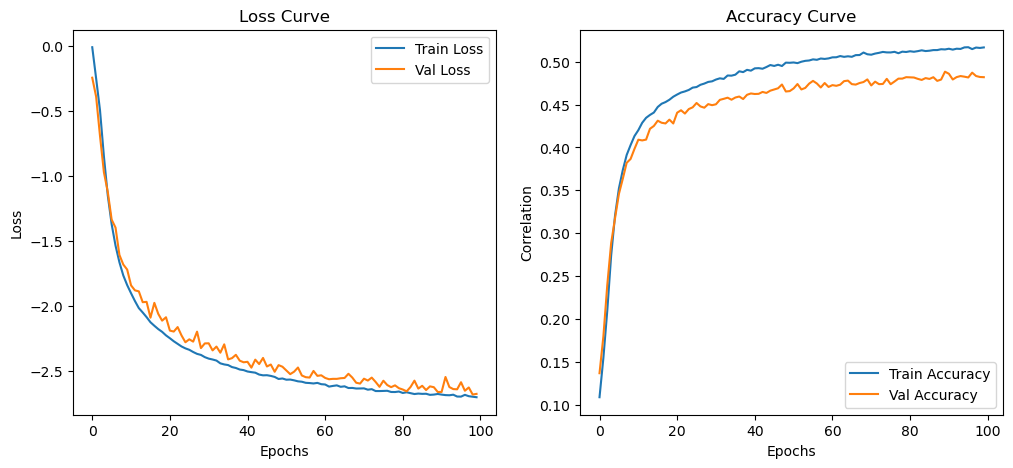

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None,
    'drop_p': 0.1,
    'stack_ksizes': [3, 3],
    'stack_chans': [None, None],
    'paddings': [1, 1]  # if needed
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
results = train_model(h5_path, hyperparams)

In [9]:
def plot_neuron_predictions(results, start=0, end=40):
    if end is None:
        end = results['all_targets'].shape[0]  # Full length if not specified

    # Plot True vs. Predicted for 9 neurons (training data)
    print(f"\nPlotting training data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Training)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot for validation data
    print(f"\nPlotting validation data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_val_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_val_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Validation)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


In [10]:
import json

def save_training_results(results, filename="LinearStackedBNCNN_training_results.json"):
    # Create a copy to avoid modifying the original
    results_to_save = results.copy()

    # Remove the model (can't be JSON-serialized)
    model = results_to_save.pop('model')  # Save separately with torch.save

    # Convert numpy arrays to lists
    for key, value in results_to_save.items():
        if isinstance(value, np.ndarray):
            results_to_save[key] = value.tolist()

    # Save to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results_to_save, f, indent=4)  # indent=4 for readability

    print(f"Results saved to {filename} (excluding model)")

# Example usage after training:
save_training_results(results)

Results saved to LinearStackedBNCNN_training_results.json (excluding model)


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_training_results(filename="LinearStackedBNCNN_training_results.json"):
    """Load training results from JSON file and convert lists back to numpy arrays"""
    with open(filename, 'r', encoding='utf-8') as f:
        results = json.load(f)

    # Convert lists back to numpy arrays for the prediction/target data
    array_keys = ['all_predictions', 'all_targets', 'all_val_predictions', 'all_val_targets']
    for key in array_keys:
        if key in results:
            results[key] = np.array(results[key])

    return results


Plotting training data predictions from 0 to 40:


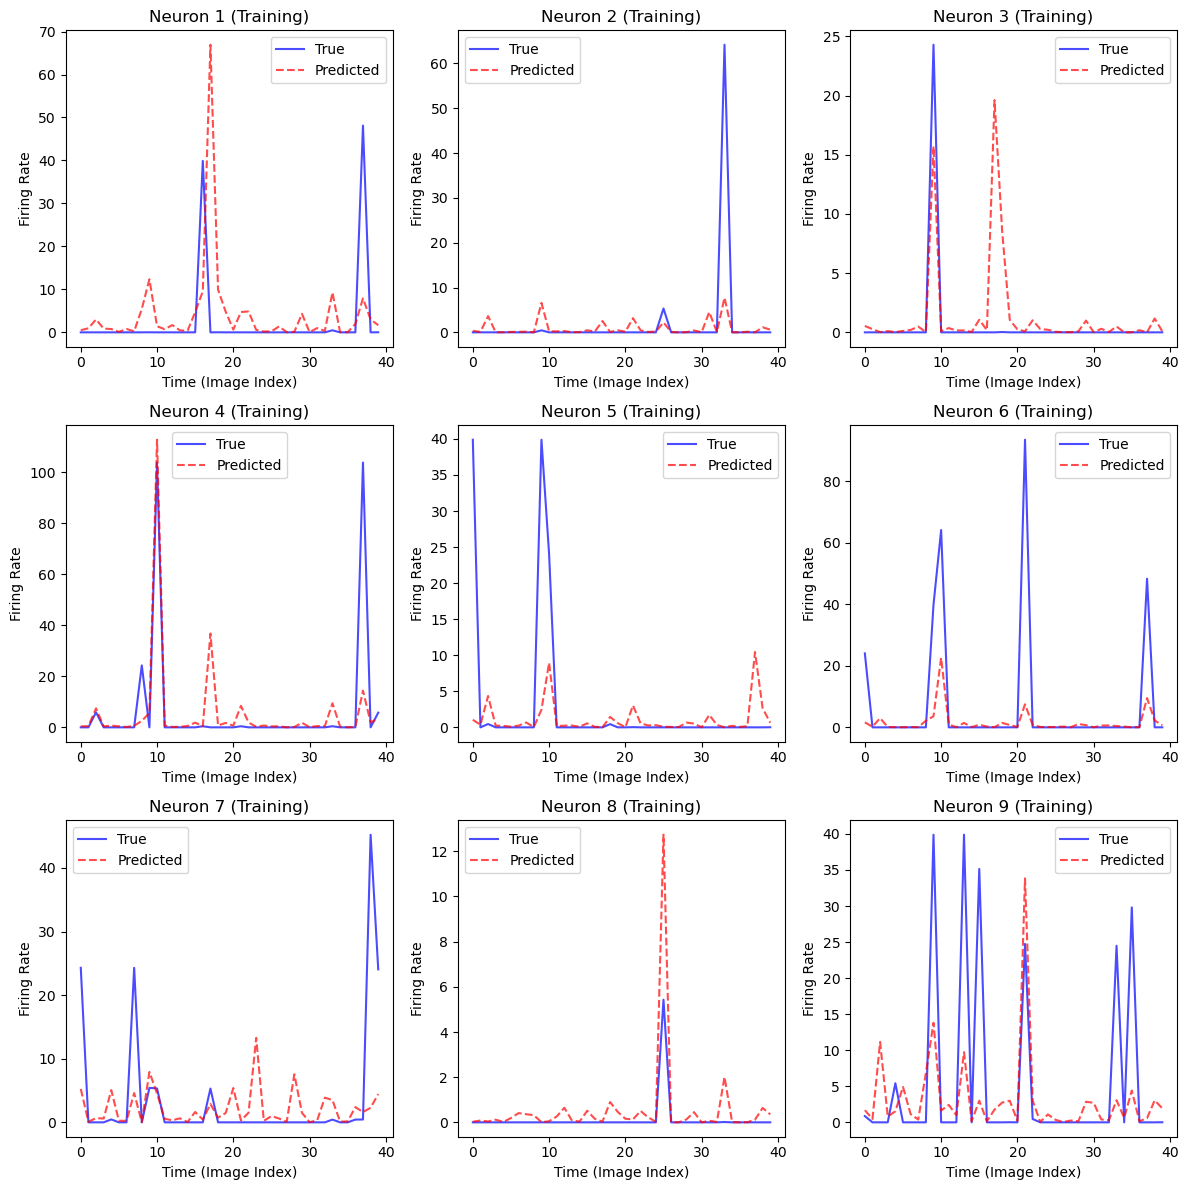


Plotting validation data predictions from 0 to 40:


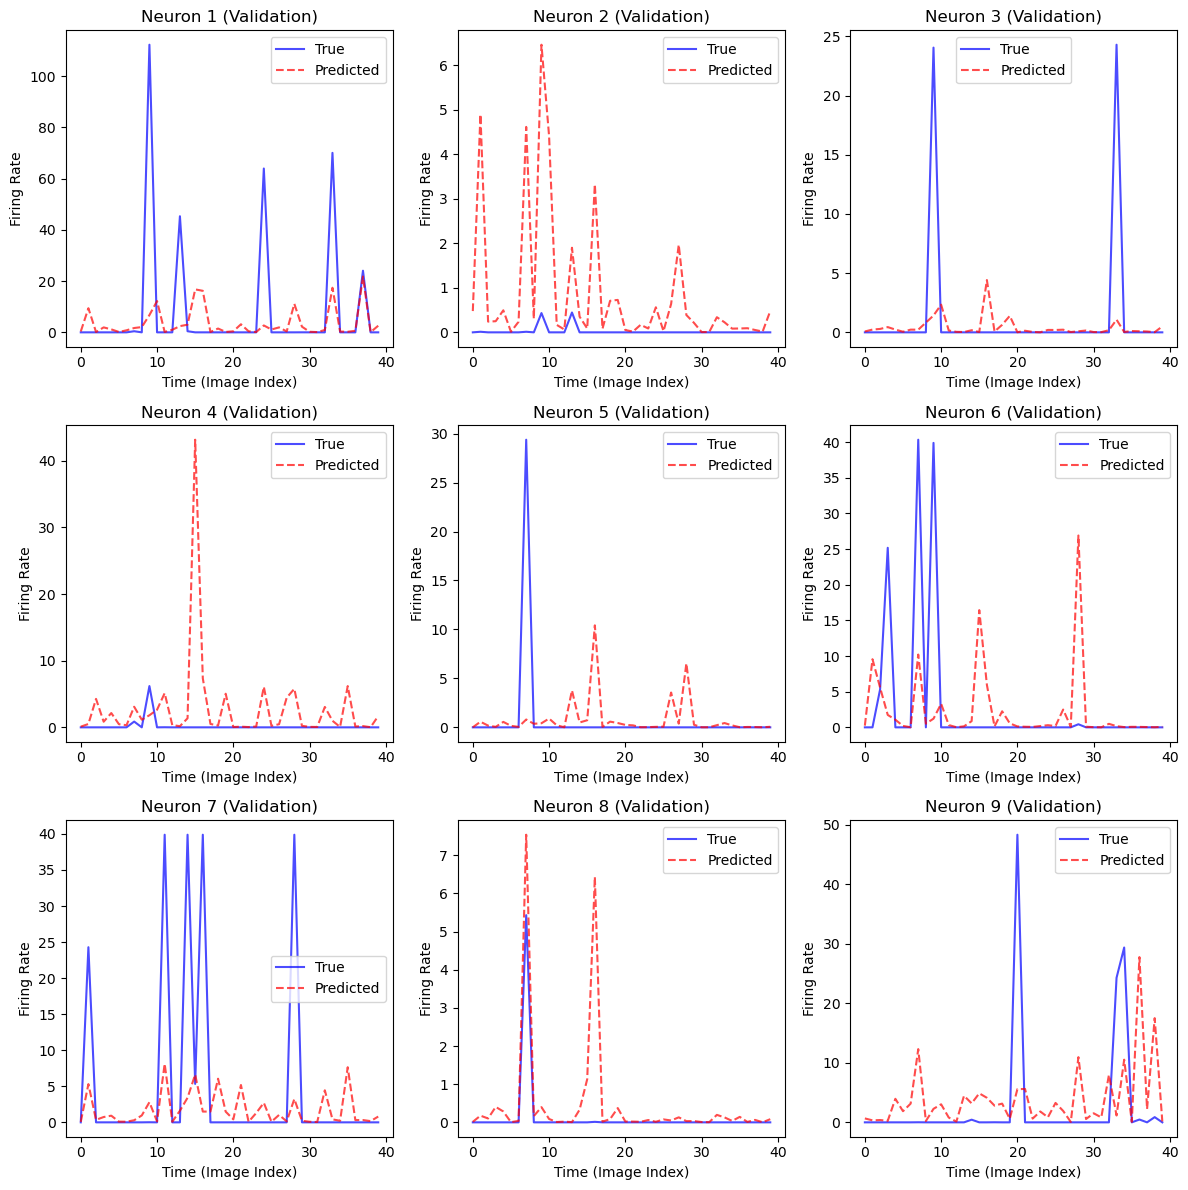

In [12]:
# Load the saved results
loaded_results = load_training_results("LinearStackedBNCNN_training_results.json")

# Pass to your plotting function
plot_neuron_predictions(loaded_results)